# Cellpose

github: https://github.com/mouseland/cellpose <br>
data: http://www.cellpose.org/dataset <br>
paper: http://www.cellpose.org/dataset <br>

In [156]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
import os, sys
import glob
import cv2
currentdir = os.path.dirname(os.path.realpath('run_cellpose.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

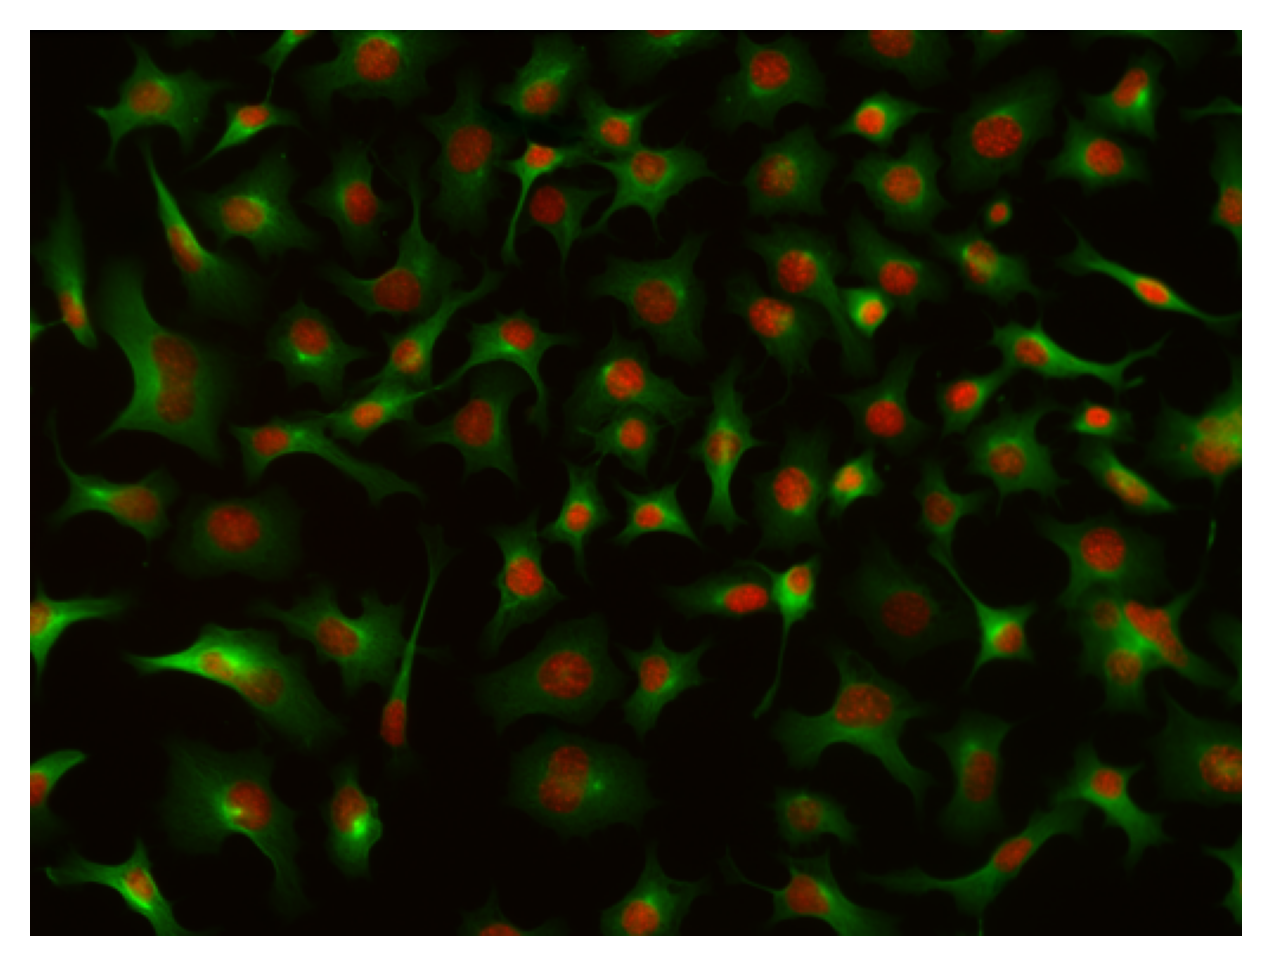

In [159]:
img =plt.imread('../data/cellpose/000_img.png')
plt.imshow(img)
plt.axis('off')
plt.show()

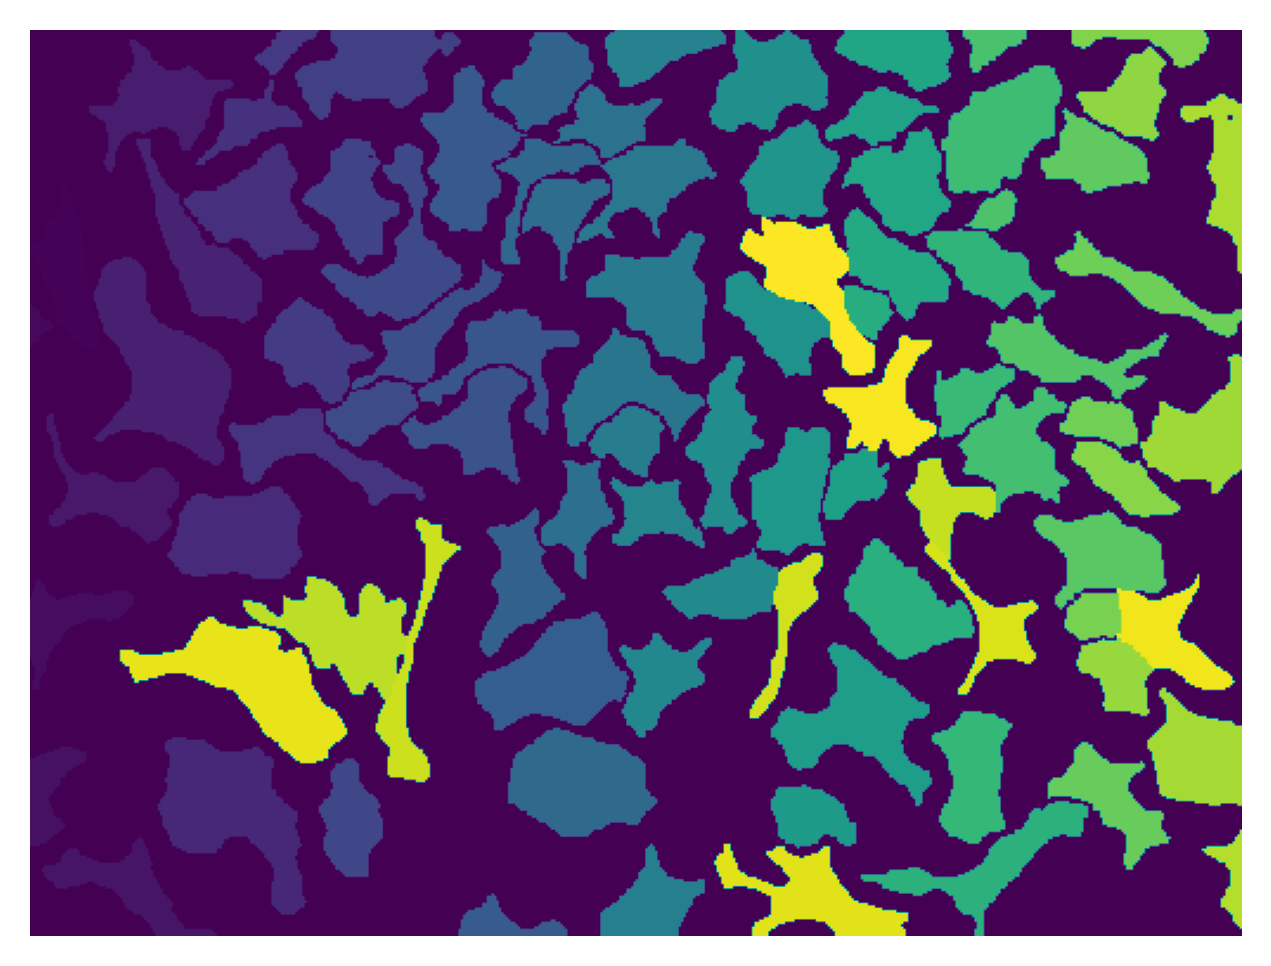

In [178]:
masks =plt.imread('../data/cellpose/000_masks.png')
plt.imshow(masks)
plt.axis('off')
plt.show()

In [200]:
['%f' % number for number in  np.unique(masks)][:5]

['0.000000', '0.000015', '0.000031', '0.000046', '0.000061']

In [202]:
labels = masks
# Map component labels to hue val, 0-179 is the hue range in OpenCV
label_hue = np.uint8(179 * labels /np.max(labels))
np.unique(label_hue)

array([  0,   1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,
        25,  27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,
        51,  53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,
        77,  79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101,
       103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127,
       129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153,
       155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179],
      dtype=uint8)

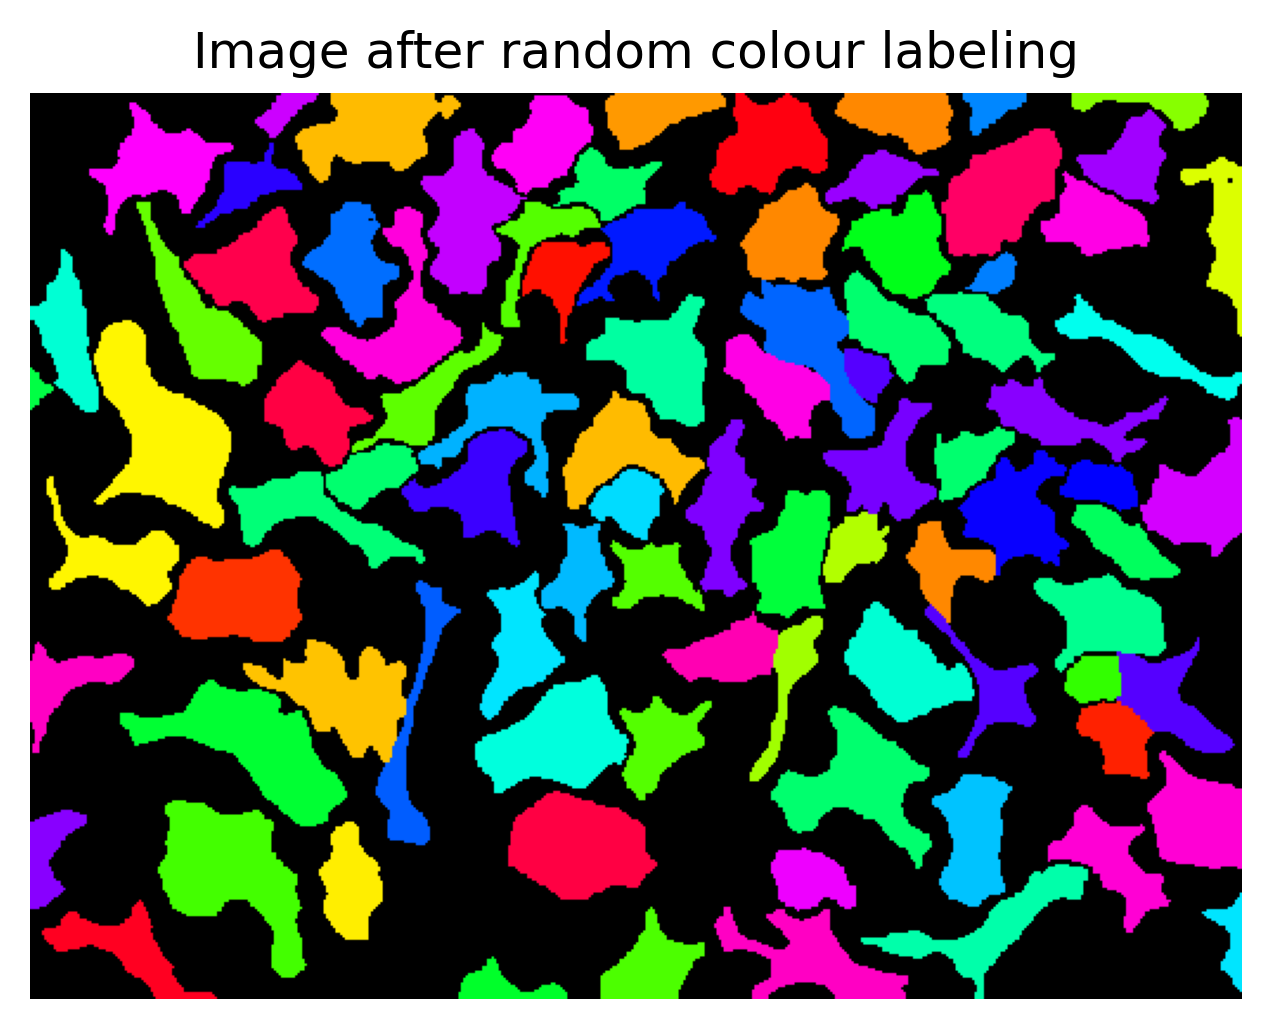

In [208]:
labels = masks

# Map component labels to hue val, 0-179 is the hue range in OpenCV
label_hue = np.uint8(179*labels/np.max(labels))
palette = np.arange(1, 179)
list_rand_nums = np.random.randint(1,179, 179)
# list_rand_nums gives the new values you wish palette to be mapped to.
index = np.digitize(label_hue.ravel(), palette, right=True)
random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

# Converting cvt to BGR
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

#Showing Image after Component Labeling
plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
plt.axis('off')
plt.title("Image after random colour labeling")
plt.show()

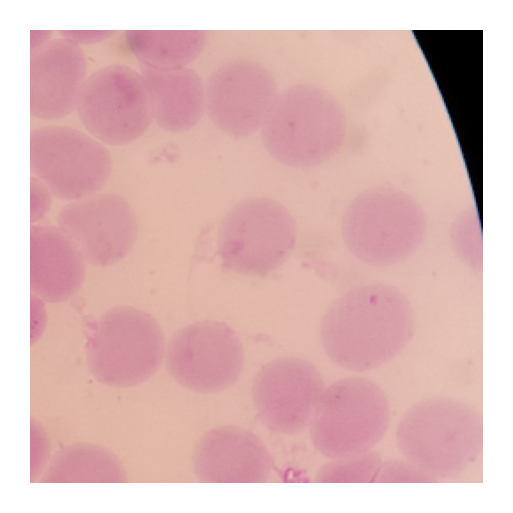

In [138]:
org_files = ['../data/testing_openflexure/2021-03-05_15-50-16_0_0_5578.jpeg', 
            '../data/fit_to_circle/cropped_P201_IMG_20151029_162934.jpg',
            '../data/fit_to_circle/cropped_P50_IMG_20150820_162504.jpg',
             '../data/cropped/IMG_20150820_162504/img/slice_IMG_20150820_162504_512_512_256_256_0.png',
             '../data/cropped/IMG_20150820_162504/img/slice_IMG_20150820_162504_256_512_256_256_0.png',
             '../data/cropped/IMG_20150820_162504/img/slice_IMG_20150820_162504_256_1024_256_256_0.png',
            ]

# view 1 image
img = io.imread(org_files[-1])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [139]:
def mask_rgb(masks, colors=None):
    """ masks in random rgb colors
    Parameters
    ----------------
    masks: int, 2D array
        masks where 0=NO masks; 1,2,...=mask labels
    colors: int, 2D array (optional, default None)
        size [nmasks x 3], each entry is a color in 0-255 range
    Returns
    ----------------
    RGB: uint8, 3D array
        array of masks overlaid on grayscale image
    """
    if colors is not None:
        if colors.max()>1:
            colors = np.float32(colors)
            colors /= 255
        colors = utils.rgb_to_hsv(colors)
    
    HSV = np.zeros((masks.shape[0], masks.shape[1], 3), np.float32)
    HSV[:,:,2] = 1.0
    for n in range(int(masks.max())):
        ipix = (masks==n+1).nonzero()
        if colors is None:
            HSV[ipix[0],ipix[1],0] = np.random.rand()
        else:
            HSV[ipix[0],ipix[1],0] = colors[n,0]
        HSV[ipix[0],ipix[1],1] = np.random.rand()*0.5+0.5
        HSV[ipix[0],ipix[1],2] = np.random.rand()*0.5+0.5
    RGB = (utils.hsv_to_rgb(HSV) * 255).astype(np.uint8)
    return RGB

def mask_overlay(img, masks, colors=None):
    """ overlay masks on image (set image to grayscale)
    Parameters
    ----------------
    img: int or float, 2D or 3D array
        img is of size [Ly x Lx (x nchan)]
    masks: int, 2D array
        masks where 0=NO masks; 1,2,...=mask labels
    colors: int, 2D array (optional, default None)
        size [nmasks x 3], each entry is a color in 0-255 range
    Returns
    ----------------
    RGB: uint8, 3D array
        array of masks overlaid on grayscale image
    """
    if colors is not None:
        if colors.max()>1:
            colors = np.float32(colors)
            colors /= 255
        colors = utils.rgb_to_hsv(colors)
    if img.ndim>2:
        img = img.astype(np.float32).mean(axis=-1)
    else:
        img = img.astype(np.float32)
    img = utils.normalize99(img)
    img -= img.min()
    img /= img.max()
    HSV = np.zeros((img.shape[0], img.shape[1], 3), np.float32)
    HSV[:,:,2] = np.clip(img*1.5, 0, 1.0)
    for n in range(int(masks.max())):
        ipix = (masks==n+1).nonzero()
        if colors is None:
            HSV[ipix[0],ipix[1],0] = np.random.rand()
        else:
            HSV[ipix[0],ipix[1],0] = colors[n,0]
        HSV[ipix[0],ipix[1],1] = 1.0
    RGB = (utils.hsv_to_rgb(HSV) * 255).astype(np.uint8)
    return RGB

def image_to_rgb(img0, channels=[0,0]):
    """ image is 2 x Ly x Lx or Ly x Lx x 2 - change to RGB Ly x Lx x 3 """
    img = img0.copy()
    img = img.astype(np.float32)
    if img.ndim<3:
        img = img[:,:,np.newaxis]
    if img.shape[0]<5:
        img = np.transpose(img, (1,2,0))
    if channels[0]==0:
        img = img.mean(axis=-1)[:,:,np.newaxis]
    for i in range(img.shape[-1]):
        if np.ptp(img[:,:,i])>0:
            img[:,:,i] = utils.normalize99(img[:,:,i])
            img[:,:,i] = np.clip(img[:,:,i], 0, 1)
    img *= 255
    img = np.uint8(img)
    RGB = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    if img.shape[-1]==1:
        RGB = np.tile(img,(1,1,3))
    else:
        RGB[:,:,channels[0]-1] = img[:,:,0]
        if channels[1] > 0:
            RGB[:,:,channels[1]-1] = img[:,:,1]
    return RGB

def interesting_patch(mask, bsize=130):
    """ get patch of size bsize x bsize with most masks """
    Ly,Lx = mask.shape
    m = np.float32(mask>0)
    m = gaussian_filter(m, bsize/2)
    y,x = np.unravel_index(np.argmax(m), m.shape)
    ycent = max(bsize//2, min(y, Ly-bsize//2))
    xcent = max(bsize//2, min(x, Lx-bsize//2))
    patch = [np.arange(ycent-bsize//2, ycent+bsize//2, 1, int),
             np.arange(xcent-bsize//2, xcent+bsize//2, 1, int)]
    return patch

def disk(med, r, Ly, Lx):
    """ returns pixels of disk with radius r and center med """
    yy, xx = np.meshgrid(np.arange(0,Ly,1,int), np.arange(0,Lx,1,int),
                         indexing='ij')
    inds = ((yy-med[0])**2 + (xx-med[1])**2)**0.5 <= r
    y = yy[inds].flatten()
    x = xx[inds].flatten()
    return y,x

In [140]:
imgs = [cv2.imread(img_path) for img_path in org_files]

In [141]:
img_height = 512
img_width = 512
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [142]:
imgs_red[0].shape

(512, 512, 3)

In [153]:
# RUN CELLPOSE

from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,1], [0,1], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
# for chan, img in zip(channels, imgs_red):
masks_all = []

for img in imgs_red:
    chan = [0, 0] # for black and white imgs
    #img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=50, channels=chan)

    masks_all.append(masks)
    
    # # save results so you can load in gui
    # io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # # save results as png
    # io.save_to_png(img, masks, flows, filename)

** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)
time spent: running network 0.39s; flow+mask computation 0.30
estimated masks for 1 image(s) in 0.69 sec
>>>> TOTAL TIME 0.69 sec
processing 1 image(s)
time spent: running network 0.36s; flow+mask computation 0.46
estimated masks for 1 image(s) in 0.83 sec
>>>> TOTAL TIME 0.83 sec
processing 1 image(s)
time spent: running network 0.37s; flow+mask computation 0.38
estimated masks for 1 image(s) in 0.76 sec
>>>> TOTAL TIME 0.76 sec
processing 1 image(s)
time spent: running network 0.36s; flow+mask computation 0.46
estimated masks for 1 image(s) in 0.83 sec
>>>> TOTAL TIME 0.83 sec
processing 1 image(s)
time spent: running network 0.37s; flow+mask computation 0.44
estimated masks for 1 image(s) in 0.82 sec
>>>> TOTAL TIME 0.82 sec
processing 1 image(s)
time spent: running network 0.37s; flow+mask computation 0.20
estimated masks for 1 image(s) in 0.58 sec
>>>> TOTAL TIME 0.58 sec


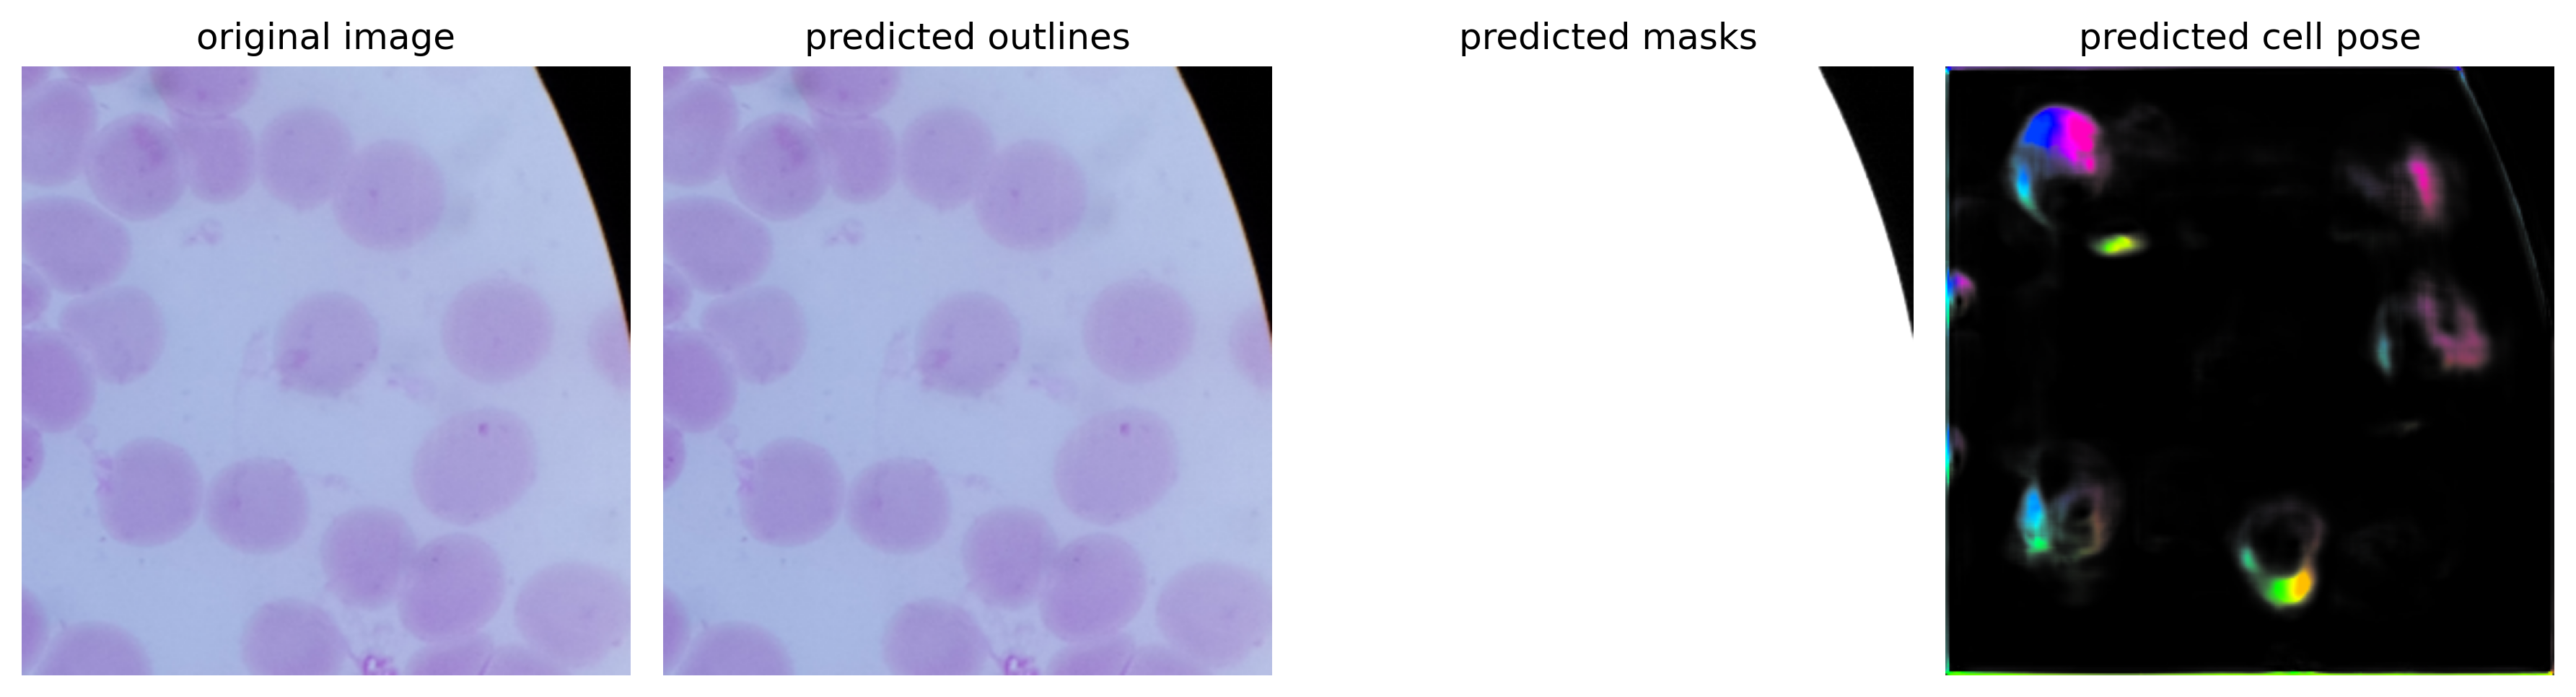

In [154]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

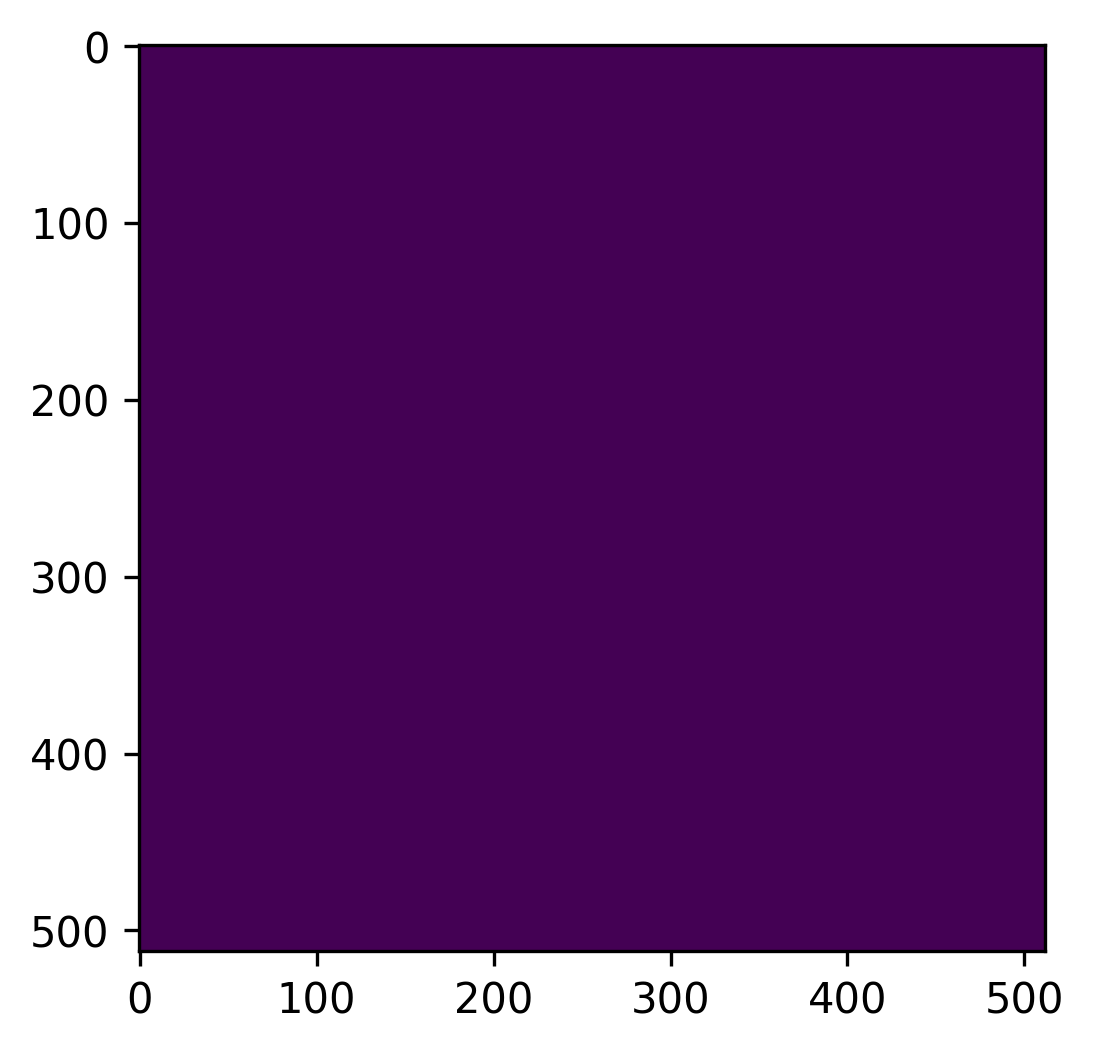

In [155]:
plt.imshow(masks)

(-0.5, 511.5, 511.5, -0.5)

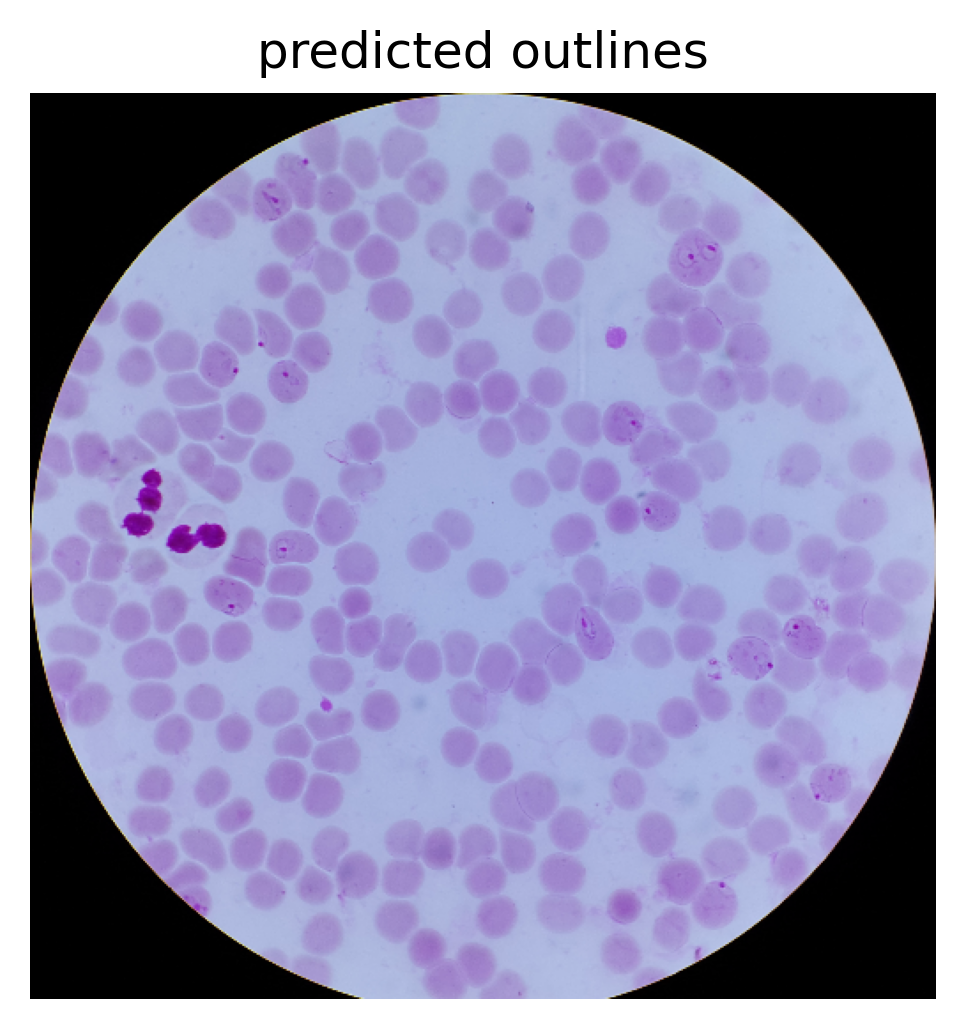

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111)
outlines = utils.masks_to_outlines(masks_all[-3])
outX, outY = np.nonzero(outlines)
imgout= imgs_red[-3].copy()
imgout[outX, outY] = np.array([255,75,75])
ax.imshow(imgout)
#for o in outpix:
#    ax.plot(o[:,0], o[:,1], color=[1,0,0], lw=1)
ax.set_title('predicted outlines')
ax.axis('off')

In [119]:
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [120]:
!pip install imantics

In [64]:
import numpy as np
from imantics import Polygons, Mask
from shapely.geometry.polygon import Polygon as Polygon_shapley

# This can be any array

polygons = Mask(masks).polygons()

print(polygons.points)
print(polygons.segmentation)

[array([[335, 449],
       [334, 450],
       [331, 450],
       [328, 453],
       [328, 454],
       [327, 455],
       [327, 456],
       [326, 457],
       [326, 463],
       [327, 464],
       [327, 465],
       [328, 466],
       [328, 467],
       [331, 470],
       [341, 470],
       [345, 466],
       [345, 465],
       [347, 463],
       [347, 457],
       [346, 456],
       [346, 455],
       [344, 453],
       [344, 452],
       [343, 451],
       [342, 451],
       [341, 450],
       [338, 450],
       [337, 449]]), array([[228, 415],
       [225, 418],
       [224, 418],
       [224, 419],
       [223, 420],
       [223, 422],
       [222, 423],
       [222, 425],
       [221, 426],
       [221, 435],
       [224, 438],
       [228, 438],
       [229, 439],
       [233, 439],
       [234, 438],
       [236, 438],
       [239, 435],
       [240, 435],
       [240, 430],
       [241, 429],
       [241, 424],
       [240, 423],
       [240, 420],
       [239, 419],
       [2

AssertionError: 

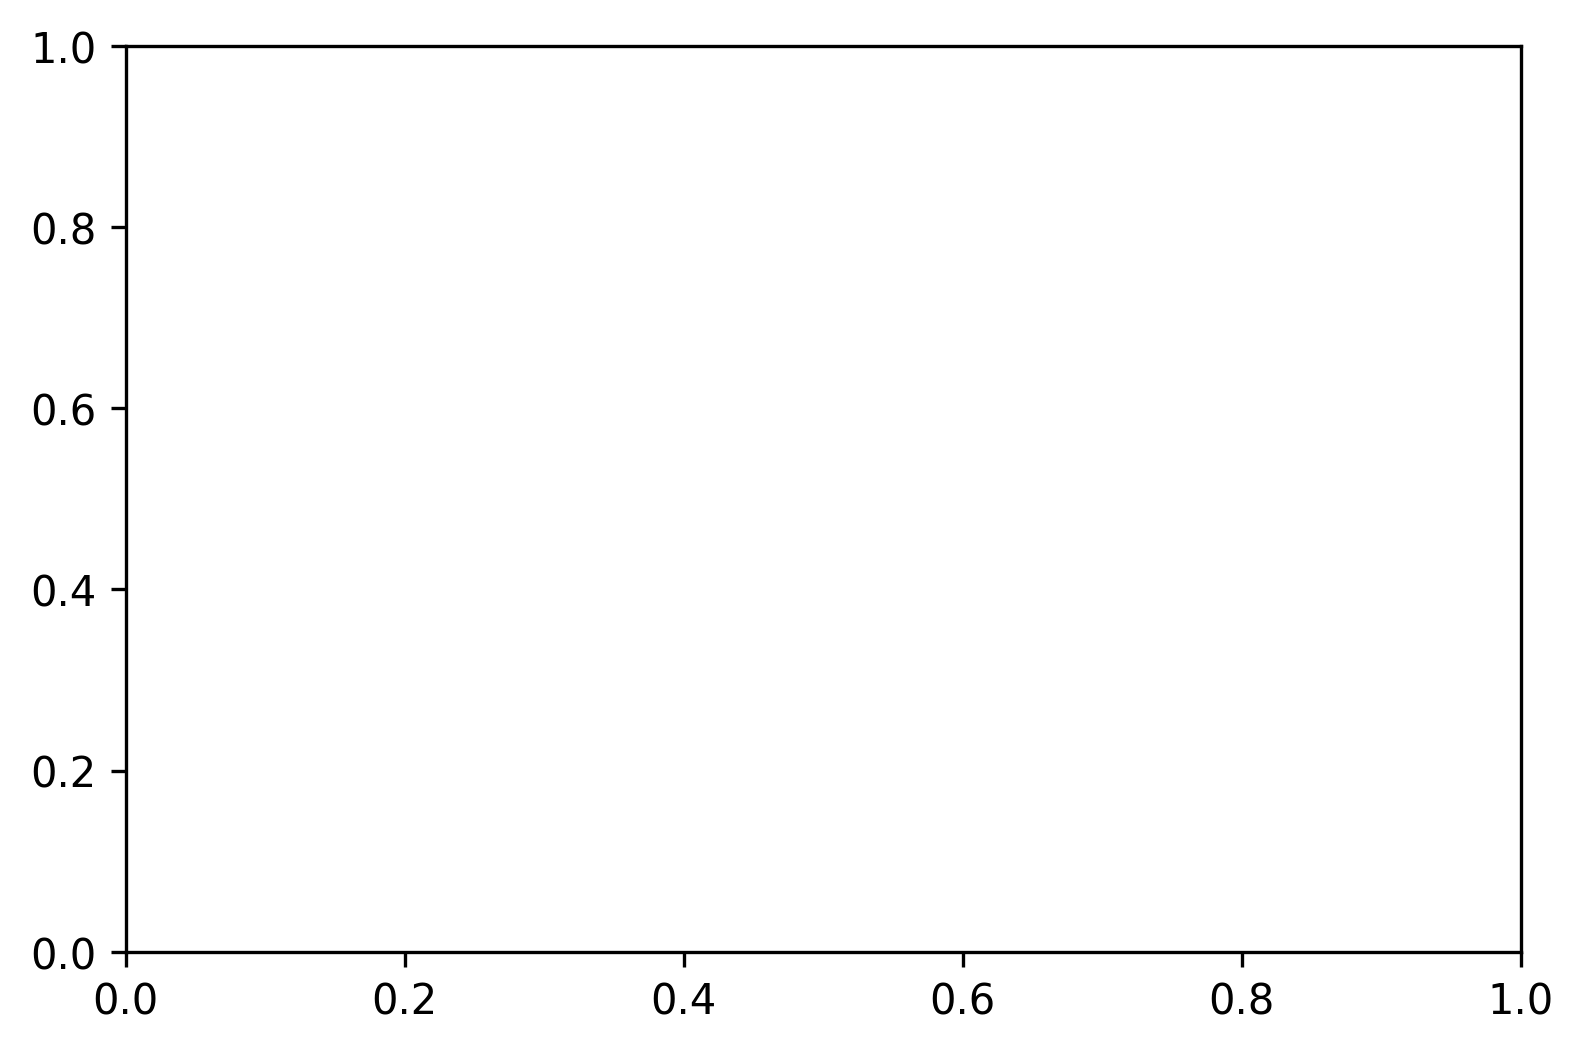

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)

poly = Polygon_shapley(polygons.points)
x,y = poly.exterior.xy
ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
ax.imshow(overlayimgs_red[-1])

In [ ]:
import mask-to-polygons

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
overlay = mask_overlay(imgs_red[1], masks)
ax.imshow(overlay)
ax.set_title('predicted masks')
ax.axis('off')